## Capstone Project 1: Beijing House Price Predictions
## VI. Modeling

In this section, we will build a regression model to predict the housing price. We will try out several regression models and then select the model with lowest RMSE for parameter tuning. 

**Table of Contents**

1. [Load Packages and Data](#Load-Packages-and-Data)
2. [Visualize Target Feature](#Visualize-Target-Feature)
3. [Prepare Data Sets for Modeling](#Prepare-Data-Sets-for-Modeling)
4. [Build Initial Models](#Build-Initial-Models)
5. [Parameter Tuning on The Chosen Model](#Parameter-Tuning-on-The-Chosen-Model)


<a id="Load-Packages-and-Data"></a>
### Load Packages and Data


In [1]:
#import packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sklearn
%matplotlib inline

sns.set()
sns.set_style("whitegrid")

In [2]:
#Load Data
df = pd.read_csv('Data/BeijingHousePricing_Cleaned.csv', parse_dates=['tradeTime'],index_col= 'id', 
                 dtype={'buildingType' : 'category', 'renovationCondition' : 'category',
                        'buildingStructure' : 'category', 'elevator' : 'category',
                        'fiveYearsProperty' : 'category', 'subway' : 'category',
                        'district' : 'category', 'floorPosition' : 'category'})
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.sort_values('tradeTime', ascending = True, inplace=True)

/Users/NancyMao/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Prepare plot functions
def get_sub_plots(n_total_cols, n_cols, label_font_size = 14, tick_font_size = 13):
    n_rows = int(n_total_cols / n_cols)
    if n_total_cols % n_cols != 0:
        n_rows += 1

    fig, axes = plt.subplots(nrows = n_rows,
                             ncols = n_cols,
                             squeeze = False)
    
    
    fig.set_size_inches(10 * n_cols, 8 * n_rows)  
    
    if n_total_cols % n_cols != 0:
        for col in range(n_total_cols % n_cols, n_cols):
            fig.delaxes(axes[n_rows - 1][col])

    axes = axes.flatten()
    
    for ax in axes:
        ax.tick_params(labelsize = tick_font_size)
        ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)

    return (fig, axes)

<a id="Visualize-Target-Feature"></a>
### Visualize Target Feature

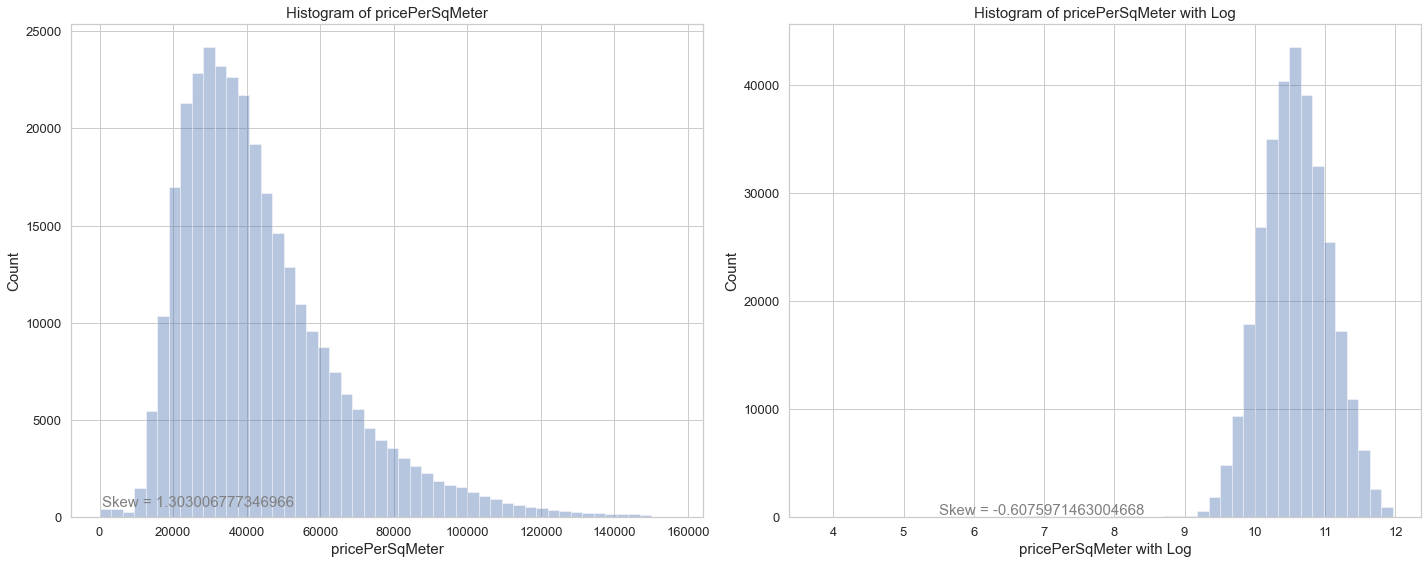

In [4]:
fig, axes = get_sub_plots(2, 2) 
style = dict(size = 15, color = 'gray')
    
x = pd.Series(df.pricePerSqMeter, name = 'pricePerSqMeter')
log_x = pd.Series(np.log(x), name = 'Taking log on ' + 'pricePerSqMeter')

sns.distplot(x, kde = False, ax = axes[0])
axes[0].text(600, 550, 'Skew = ' + str(x.skew()), **style)
axes[0].set_title('Histogram of ' + 'pricePerSqMeter', fontsize = 15)
axes[0].set_xlabel('pricePerSqMeter', fontsize = 15)
axes[0].set_ylabel('Count', fontsize = 15)

sns.distplot(log_x, kde = False, ax = axes[1])
axes[1].text(5.5, 280, 'Skew = ' + str(log_x.skew()), **style)
axes[1].set_title('Histogram of ' + 'pricePerSqMeter' + ' with Log', fontsize = 15)
axes[1].set_xlabel('pricePerSqMeter' + ' with Log', fontsize = 15)
axes[1].set_ylabel('Count', fontsize = 15)
    
fig.tight_layout()    
plt.show()

The Target Feature is skewed. Its distribution is normalized with logarithm transformation. 

Since most linear regression models do not deal well with non-normal data, we will conduct log transformation on target when building linear models such as linear regression, ridge and lasso. 

<a id="Prepare-Data-Sets-for-Modeling"></a>
### Prepare Data Sets for Modeling

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR

In [6]:
# Create New Feature - the floor where the house is at in the building

def floorNumber(df):
    if df['floorPosition'] == 'top' :
        value = df['buildingFloors'] * 1
    if df['floorPosition'] == 'high':
        value = round(df['buildingFloors'] * 0.75)
    if df['floorPosition'] == 'middle':
        value = round(df['buildingFloors'] * 0.5)
    if df['floorPosition'] == 'low':
        value = round(df['buildingFloors'] * 0.25)
    if df['floorPosition'] == 'bottom':
        value = 1
    return value

In [7]:
df['floorNumber'] = df.apply(floorNumber, axis=1)

In [9]:
# Define functions to transform X and also export transformed feature labels
def transformerX (X, features_in):
    X_ft = X[features]
    
    X_num = X_ft.select_dtypes(include=['number'])
    X_cat = X_ft.select_dtypes(include=['category'])
    
    num_attribs = list(X_num)
    cat_attribs = list(X_cat)
    
    t = ColumnTransformer([
    ('num_std_scaler', StandardScaler(), num_attribs), #standardize numeric
    ('cat_1hot', OneHotEncoder(handle_unknown='ignore'), cat_attribs), #1hotencoder on categories
    ])
    

    t.fit(X_ft)
    cat_attribs_out = list(t.transformers_[1][1].get_feature_names(cat_attribs)) #get transformed feature labels of categorical data
    
    features_out = num_attribs + cat_attribs_out #combine new cat. labels and numeric labels
    
    X_cleaned = t.fit_transform(X_ft)
       
    return X_cleaned, features_out

In [10]:
#Prepare X and y
X_full = df.drop(['totalPrice', 'pricePerSqMeter'], axis = 1)
X_full.tradeTime = pd.to_numeric(X_full.tradeTime) #convert datetime to numeric
y = df.pricePerSqMeter

In [11]:
#features to include in the models
features = ['Lng', 'Lat',
            'tradeTime', 'DOM', 'followers','bedRoom',
            'livingRoom', 'kitchen', 'bathRoom', 'buildingType', 'constructionTime',
            'renovationCondition', 'buildingStructure', 'elevator',
            'fiveYearsProperty', 'subway', 'district', 'communityAverage', 'floorNumber']

#split train and test set
X_train, X_test, y_train, y_test = train_test_split(X_full, y, random_state = 42, test_size = .3)

X_train_cleaned, X_train_label = transformerX(X_train, features)
y_train_log = np.log1p(y_train)
X_test_cleaned, X_test_label = transformerX(X_test, features)
y_test_log = np.log1p(y_test)

In [12]:
#Define metrics
def rmse(y_true, y_predict, log1p=False):
    if log1p == True:
        y_true = np.expm1(y_true)
        y_predict = np.expm1(y_predict)
    return np.sqrt(mean_squared_error(y_true, y_predict))

#rmse_scorer_nolog = make_scorer(rmse, greater_is_better=False, log1p=False)

In [13]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 42)

<a id="Build-Initial-Models"></a>
### Build Initial Models

In [14]:
Models = ['SVR', 'Linear', 'Ridge', 'Lasso', 'RandomForest', 'GradientBoosting']
Linear_Models = ['Linear', 'Ridge', 'Lasso']
modelRmse = pd.DataFrame(columns=['model', 'train_RMSE', 'test_RMSE'])

lr = LinearRegression()
lr.fit(X_train_cleaned, y_train_log)
modelRmse = modelRmse.append({'model':'LR', 
                              'train_RMSE': rmse(y_train_log, lr.predict(X_train_cleaned), log1p = True), 
                              'test_RMSE': rmse(y_test_log, lr.predict(X_test_cleaned), log1p = True)}, 
                             ignore_index = True)


ridge = Ridge(alpha = 5)
ridge.fit(X_train_cleaned, y_train_log)
modelRmse = modelRmse.append({'model':'RIDGE', 
                              'train_RMSE': rmse(y_train_log, ridge.predict(X_train_cleaned), log1p = True), 
                              'test_RMSE': rmse(y_test_log, ridge.predict(X_test_cleaned), log1p = True)}, 
                             ignore_index = True)

lasso = Lasso(alpha = 5)
lasso.fit(X_train_cleaned, y_train_log)
modelRmse = modelRmse.append({'model':'LASSO', 
                              'train_RMSE': rmse(y_train_log, lasso.predict(X_train_cleaned), log1p = True), 
                              'test_RMSE': rmse(y_test_log, lasso.predict(X_test_cleaned), log1p = True)}, 
                             ignore_index = True)

lsvr = LinearSVR()
lsvr.fit(X_train_cleaned, y_train)
modelRmse = modelRmse.append({'model':'LSVR',
                              'train_RMSE': rmse(y_train, lsvr.predict(X_train_cleaned)), 
                              'test_RMSE': rmse(y_test, lsvr.predict(X_test_cleaned))}, 
                            ignore_index = True)

rf = RandomForestRegressor(n_estimators=50, random_state=42, max_depth=20, min_samples_leaf=5, n_jobs=-1)
rf.fit(X_train_cleaned, y_train)
modelRmse = modelRmse.append({'model':'RF', 
                              'train_RMSE': rmse(y_train, rf.predict(X_train_cleaned)), 
                              'test_RMSE': rmse(y_test, rf.predict(X_test_cleaned))}, 
                            ignore_index = True)

gbr = GradientBoostingRegressor(n_estimators=50, random_state=42, max_depth=20, min_samples_leaf=5)
gbr.fit(X_train_cleaned, y_train)
modelRmse = modelRmse.append({'model':'GB', 
                              'train_RMSE': rmse(y_train, gbr.predict(X_train_cleaned)),
                              'test_RMSE': rmse(y_test, gbr.predict(X_test_cleaned))}, 
                            ignore_index = True)



In [15]:
modelRmse

,model,train_RMSE,test_RMSE
0,LR,8944.587,8962.582
1,RIDGE,8941.056,8958.310
2,LASSO,22216.348,22037.518
3,LSVR,10764.828,10708.901
4,RF,3710.491,5204.277
5,GB,1338.953,5150.458


Random Forest and Gradient Boosting have better performance in terms of low RMSE but Gradient Boosting tends to overfit more than Random Forest. We will choose **Random Forest** as our regression model and conduct hyper parameter tuning to see if we can improve the performance. 

Let's take a look at the feature importances in the Random Forest model before we move forward with hyper parameter tuning. 

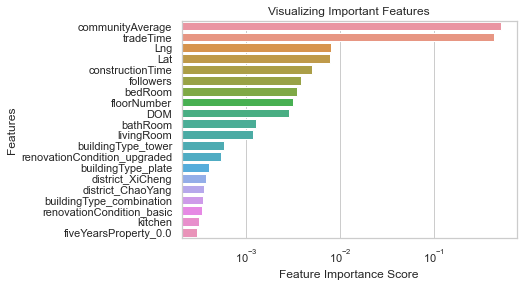

In [16]:
#Visualize Feature Importances of Random Forest model
feature_imp = pd.Series(rf.feature_importances_, index=X_train_label, name='Feature Inportances').sort_values(ascending=False)
feature_imp_list = pd.DataFrame(feature_imp)
g = sns.barplot(x=feature_imp[:20], y=feature_imp.index[:20])
g.set_xscale("log")
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

<a id="Parameter-Tuning-on-The-Chosen-Model"></a>
### Parameter Tuning on The Chosen Model

First we will explore how each of the parameter impact on the model performance

In [17]:
def rf_param(parameter, param_values, x_train, y_train, x_test, y_test):
    train_results = []
    test_results = []
    for value in param_values:
        if parameter == 'n_estimators':
            rf = RandomForestRegressor(n_estimators=value, max_depth=20,
                                        min_samples_leaf=10, 
                                        random_state=42, verbose=0, n_jobs=-1)
        elif parameter == 'max_depth':
            rf = RandomForestRegressor(n_estimators=50, max_depth=value,
                                        min_samples_leaf=10, 
                                        random_state=42, verbose=0, n_jobs=-1)
        elif parameter == 'min_samples_leaf':
            rf = RandomForestRegressor(n_estimators=50, max_depth=20,
                                        min_samples_leaf=value, 
                                        random_state=42, verbose=0, n_jobs=-1)
        else:
            print("parameter needs to be one of ['n_estimators', 'max_depth', 'min_samples_leaf']")
            return;
        
        rf.fit(x_train, y_train)
        train_pred = rf.predict(x_train)
        rmse = mean_squared_error(y_train, train_pred, squared=False)
        train_results.append(rmse)
        y_pred = rf.predict(x_test)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        test_results.append(rmse)
            
    from matplotlib.legend_handler import HandlerLine2D
    line1, = plt.plot(param_values, train_results, c='b', label='Train RMSE')
    line2, = plt.plot(param_values, test_results, c='r', label='Test RMSE')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.title(parameter)
    plt.ylabel('RMSE')
    plt.xlabel('parameter value')
    plt.show()
    
    return pd.DataFrame(list(zip(param_values, train_results, test_results)), 
                        columns =[parameter, 'Train_RMSE', 'Test_RMSE'])
    

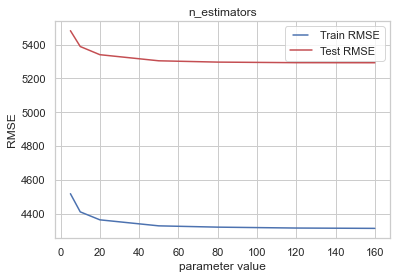

,n_estimators,Train_RMSE,Test_RMSE
0,5,4517.634,5482.954
1,10,4410.114,5389.264
2,20,4362.926,5340.849
3,50,4327.261,5304.698
4,80,4319.625,5296.962
5,120,4314.292,5293.583
6,160,4312.357,5293.137


In [18]:
parameter = 'n_estimators'
param_list = [5, 10, 20, 50, 80, 120, 160]
rf_param(parameter, param_list, X_train_cleaned, y_train, X_test_cleaned, y_test)

RMSE on test set drops as n_estimator grows and flattens out when n_estimator >80. 

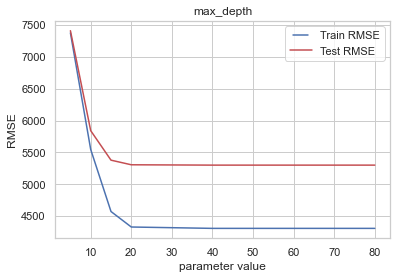

,max_depth,Train_RMSE,Test_RMSE
0,5,7376.747,7410.752
1,10,5544.708,5840.440
2,15,4570.590,5377.198
3,20,4327.261,5304.698
4,40,4305.862,5299.248
5,60,4305.862,5299.248
6,80,4305.862,5299.248


In [19]:
parameter = 'max_depth'
param_list = [5, 10, 15, 20, 40, 60, 80]
rf_param(parameter, param_list, X_train_cleaned, y_train, X_test_cleaned, y_test)

RMSE on test set drops as max_depth grows but remains the same when max_depth>40. 

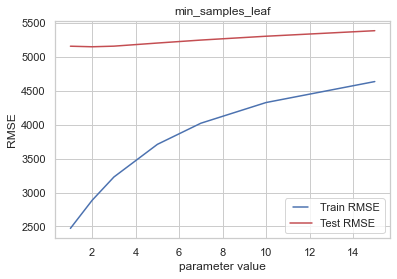

,min_samples_leaf,Train_RMSE,Test_RMSE
0,1,2471.762,5157.701
1,2,2886.098,5149.297
2,3,3229.063,5158.333
3,5,3710.491,5204.277
4,7,4022.169,5248.163
5,10,4327.261,5304.698
6,15,4636.333,5386.311


In [20]:
parameter = 'min_samples_leaf'
param_list = [1, 2, 3, 5, 7, 10, 15]
rf_param(parameter, param_list, X_train_cleaned, y_train, X_test_cleaned, y_test)

RMSE on test set keeps growing as min_samples_leaf grows. We should keep min_samples_leaf small.

In [21]:
#parameter Tuning
param_grid = {'n_estimators': [70, 80, 100],
              'max_depth': [30, 40, 50],
              'min_samples_leaf': [1,2,3,5]} 
          
cv_rf = GridSearchCV(RandomForestRegressor(random_state=42, verbose=0, n_jobs=-1), 
                     param_grid, cv = folds, n_jobs=-1, verbose=0, scoring='neg_root_mean_squared_error',
                     return_train_score=True)
cv_rf.fit(X_train_cleaned, y_train)
print('Best Params:', cv_rf.best_params_)
print('Train_Rmse:', mean_squared_error(y_train, cv_rf.predict(X_train_cleaned), squared=False))
print('Test_Rmse:', mean_squared_error(y_test, cv_rf.predict(X_test_cleaned), squared=False))

Best Params: {'max_depth': 40, 'min_samples_leaf': 2, 'n_estimators': 100}
Train_Rmse: 2545.1718902035877
Test_Rmse: 5103.172996944146


In [22]:
#Prepare functions for Scoring & Reporting

from statsmodels.graphics.regressionplots import influence_plot
from sklearn.metrics import mean_squared_error

def plot_summary(y_test, y_pred, n_total_cols = 4, n_cols = 2, fontsize = 15):
    fig, axes = get_sub_plots(n_total_cols, n_cols)
    
    sns.distplot(y_test, kde=False, hist_kws=dict(alpha=0.5), label = 'Actual', ax = axes[0])
    sns.distplot(y_pred, kde=False, hist_kws=dict(alpha=0.5), label='Aredicted', ax = axes[0])
    axes[0].legend(prop={'size': 15})
    axes[0].set_title('Histogram of predicted y vs. actual y', fontsize = fontsize)
    axes[0].set_xlabel('y', fontsize = fontsize)
    axes[0].set_ylabel('Count', fontsize = fontsize)

    sns.regplot(y_test, y_pred, fit_reg = False, ax = axes[1])
    axes[1].set_title('Actual y vs. Predicted y', fontsize = fontsize)
    axes[1].set_xlabel('Actual y', fontsize = fontsize)
    axes[1].set_ylabel('Predicted y', fontsize = fontsize)
    
    sns.regplot(y_pred, y_test - y_pred, fit_reg = False, ax = axes[2])
    axes[2].set_title('Residual Plot', fontsize = fontsize)
    axes[2].set_xlabel('Predicted y', fontsize = fontsize)
    axes[2].set_ylabel('Residuals', fontsize = fontsize)
    
    sns.distplot(y_test - y_pred, kde = False, ax = axes[3])
    axes[3].set_title('Histogram of Residuals', fontsize = fontsize)
    axes[3].set_xlabel('Residuals', fontsize = fontsize)
    axes[3].set_ylabel('Count', fontsize = fontsize)
        
    fig.tight_layout()    
    plt.show()

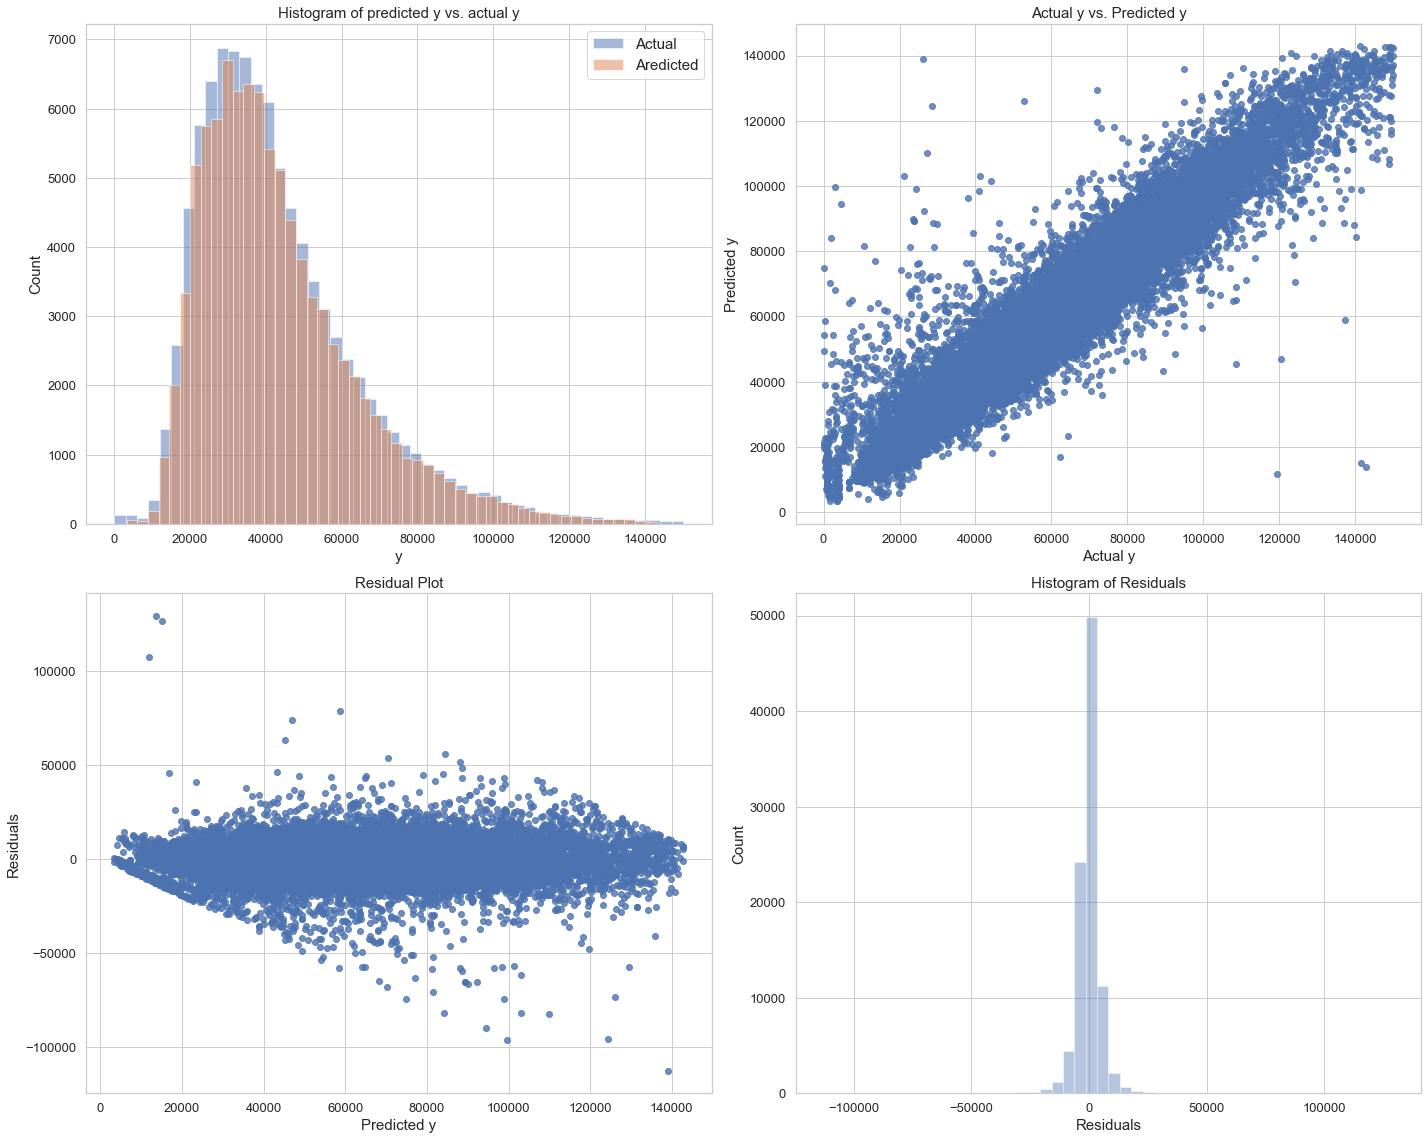

In [23]:
plot_summary(y_test, rf.predict(X_test_cleaned))